## Naudojamų kodo bibliotekų įkėlimas

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random

## Naudojamo įrenginio nustatymas (GPU ir TPU)
Galima pasirinkti, kurį įrenginį norime naudoti. Abu variantai veikia su **Google Colab** sistema, taip pat ir lokaliai.

### Kodas tikrinantis pasiekiamus GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU is available: {gpus[0]}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU is available.")

No GPU is available.


### Kodas tikrinantis pasiekiamus TPU

In [3]:
'''
try:
    # Automatiškai nustatatomas TPU ir jis inicijuojamas
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Running on TPU:", resolver.master())
    print("All devices:", tf.config.list_logical_devices('TPU'))
except Exception as e:
    print("Failed to connect to TPU:", e)
    strategy = tf.distribute.get_strategy()
'''

'\ntry:\n    # Automatiškai nustatatomas TPU ir jis inicijuojamas\n    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()\n    tf.config.experimental_connect_to_cluster(resolver)\n    tf.tpu.experimental.initialize_tpu_system(resolver)\n    strategy = tf.distribute.TPUStrategy(resolver)\n    print("Running on TPU:", resolver.master())\n    print("All devices:", tf.config.list_logical_devices(\'TPU\'))\nexcept Exception as e:\n    print("Failed to connect to TPU:", e)\n    strategy = tf.distribute.get_strategy()\n'

## Duomenų rinkinio Fashion MNIST užkrovimas naudojant TensorFlow ir Keras
Fashion MNIST duomenų rinkinys yra 28x28 paveikslėlių rinkinys, kuris sudarytas iš 60,000 mokymo pavyzdžių ir 10,000 testavimo pavyzdžių.

### Klasifikavimo klasės

Kiekvienam mokymo ir testavimo pavyzdžiui priskiriama viena iš šių klasių:

* **0** marškinėliai/palaidinė
* **1** Kelnės
* **2** Megztinis
* **3** Suknelė
* **4** Paltas
* **5** Sandalas
* **6** Marškiniai
* **7** Sportbatis
* **8** Krepšys
* **9** Batas iki kulkšnies

In [4]:
# Fashion MNIST duomenų rinkinio užkrovimas
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Sujungiami mokymo ir testavimo duomenų rinkiniai
combined_images = np.concatenate((train_images, test_images))
combined_labels = np.concatenate((train_labels, test_labels))

# Nustatomas klasių numeravimas nuo 0 iki 9
combined_labels = to_categorical(combined_labels, num_classes=10)

# Normalizuojami paveikslėliai, kad jie turėtų reikšmes tarp 0 ir 1
combined_images = combined_images.astype('float32') / 255

# Išskaidomas sujungtas duomenų rinkinys į naujus mokymo, validavimo ir testavimo rinkinius
train_images, temp_images, train_labels, temp_labels = train_test_split(
    combined_images, combined_labels, test_size=0.2, random_state=42)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=42)

# Mokymo, validavimo ir testavimo rinkinių paveikslėlių formos ir dydžiai
print("Training set images shape:", train_images.shape)
print("Validation set images shape:", val_images.shape)
print("Test set images shape:", test_images.shape)
print("Training set labels shape:", train_labels.shape)
print("Validation set labels shape:", val_labels.shape)
print("Test set labels shape:", test_labels.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training set images shape: (56000, 28, 28)
Validation set images shape: (7000, 28, 28)
Test set images shape: (7000, 28, 28)
Training set labels shape: (56000, 10)
Validation set labels shape: (7000, 10)
Test set labels shape: (7000, 10)


### Duomenų rinkinių paruošimas modelio apmokymui
Pirmiausia yra nustatoma taisyklinga duomenų rinkinio (batch) forma, tada yra išmaišomi duomenys ir iš anksto užkraunami greitiasniam mokymui.

In [5]:
batch_size = 32

# Pakeičiame paveikslėlių formą į (32, 28, 28, 1). 32 - batch dydis, 28x28 - paveikslėlio dydis, 1 - spalvų kanalų skaičius
train_images = train_images.reshape((-1, 28, 28, 1))
val_images = val_images.reshape((-1, 28, 28, 1))
test_images = test_images.reshape((-1, 28, 28, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(train_labels.size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Datasets created successfully.\n")
for images, labels in train_dataset.take(1):
  print(f'Train batch images shape: {images.shape}')
  print(f'Train batch labels shape: {labels.shape}')

for images, labels in val_dataset.take(1):
  print(f'Validation batch images shape: {images.shape}')
  print(f'Validation batch labels shape: {labels.shape}')

for images, labels in test_dataset.take(1):
  print(f'Test batch images shape: {images.shape}')
  print(f'Test batch labels shape: {labels.shape}')

Datasets created successfully.

Train batch images shape: (32, 28, 28, 1)
Train batch labels shape: (32, 10)
Validation batch images shape: (32, 28, 28, 1)
Validation batch labels shape: (32, 10)
Test batch images shape: (32, 28, 28, 1)
Test batch labels shape: (32, 10)


## Konvoliucinio neuroninio tinklo modelis sukūrimas ir apmokymas

### Modelio sukūrimas
Kadangi tyrimui atlikti reikia išbandyti daug modelio variantų ir naudojamų optimizavimo su nuostolių funkcijų, tam buvo paruošta funkcija, kuri pagal paduodamus parametrus parenka atitinkamą modelį.

In [6]:
def create_model(architecture_type, optimizer='adam', learning_rate=0.001):
  # Ši eilutė leidžia naudoti TPU (šiuo atveju neveikia, nes naudojamas GPU)
  # with strategy.scope():
  model = Sequential()
  if architecture_type == 'basic':
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

  elif architecture_type == 'intermediate':
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
  elif architecture_type == 'advanced':
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

  if optimizer == 'adam':
    opt = Adam(learning_rate=learning_rate)
  elif optimizer == 'sgd':
    opt = SGD(learning_rate=learning_rate)
  elif optimizer == 'rmsprop':
    opt = RMSprop(learning_rate=learning_rate)

  model.compile(
    optimizer=opt,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy'],
  )

  model.summary()
  return model


### Ankstyvo sustabdymo ir mokymo žingsnio dydžio mažinimo panaudojimas

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='min', min_lr=1e-8)

### Modelio apmokymas su visais skirtingais variantais (*basic, intermediate ir advanced*) ir pradiniais mokymo žingsniais (*nuo 10e-6 iki 10e-2*)

In [8]:
results = {}
learning_rates = np.logspace(-6, -2, num=5)

for architecture in ['basic', 'intermediate', 'advanced']:
  print(f"Training {architecture} model:")
  results[architecture] = {}

  for lr in learning_rates:
    # Modelio sukūrimas
    model = create_model(architecture, learning_rate=lr)

    # Modelio apmokymas
    history = model.fit(
      train_dataset,
      epochs=100,
      validation_data=val_dataset,
      callbacks=[early_stopping, reduce_lr],
    )

    # Gaunamos paskutinės epochos metrikos
    last_train_accuracy = history.history['accuracy'][-1]
    last_val_accuracy = history.history['val_accuracy'][-1]
    last_train_loss = history.history['loss'][-1]
    last_val_loss = history.history['val_loss'][-1]

    results[architecture][lr] = {
      'last_train_accuracy': last_train_accuracy,
      'last_val_accuracy': last_val_accuracy,
      'last_train_loss': last_train_loss,
      'last_val_loss': last_val_loss
    }

Training basic model:


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.1352 - loss: 2.2922 - val_accuracy: 0.2977 - val_loss: 2.2722 - learning_rate: 1.0000e-06
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.3261 - loss: 2.2633 - val_accuracy: 0.3453 - val_loss: 2.2374 - learning_rate: 1.0000e-06
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.3508 - loss: 2.2247 - val_accuracy: 0.3266 - val_loss: 2.1897 - learning_rate: 1.0000e-06
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.3247 - loss: 2.1735 - val_accuracy: 0.3000 - val_loss: 2.1269 - learning_rate: 1.0000e-06
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.3085 - loss: 2.1048 - val_accuracy: 0.3023 - val_loss: 2.0490 - learning_rate: 1.0000e-06
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.3101 - loss: 2.0233 - val_accuracy: 0.3114 - val_loss: 1.9574 - learning_rate: 1.0000e-06
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.3305 - loss: 2.1117 - val_accuracy: 0.6551 - val_loss: 1.1673 - learning_rate: 1.0000e-05
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.6778 - loss: 1.0502 - val_accuracy: 0.7167 - val_loss: 0.8801 - learning_rate: 1.0000e-05
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.7203 - loss: 0.8353 - val_accuracy: 0.7343 - val_loss: 0.7857 - learning_rate: 1.0000e-05
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7366 - loss: 0.7488 - val_accuracy: 0.7449 - val_loss: 0.7337 - learning_rate: 1.0000e-05
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.7469 - loss: 0.7124 - val_accuracy: 0.7503 - val_loss: 0.7009 - learning_rate: 1.0000e-05
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7539 - loss: 0.6755 - val_accuracy: 0.7601 - val_loss: 0.6724 - learning_rate: 1.0000e-05
Epoch 6: early stopping
Restoring m

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5987 - loss: 1.2187 - val_accuracy: 0.7849 - val_loss: 0.6095 - learning_rate: 1.0000e-04
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7868 - loss: 0.5864 - val_accuracy: 0.8126 - val_loss: 0.5370 - learning_rate: 1.0000e-04
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8098 - loss: 0.5204 - val_accuracy: 0.8183 - val_loss: 0.5165 - learning_rate: 1.0000e-04
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8260 - loss: 0.4846 - val_accuracy: 0.8270 - val_loss: 0.4826 - learning_rate: 1.0000e-04
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8339 - loss: 0.4512 - val_accuracy: 0.8456 - val_loss: 0.4441 - learning_rate: 1.0000e-04
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8429 - loss: 0.4370 - val_accuracy: 0.8489 - val_loss: 0.4355 - learning_rate: 1.0000e-04
Epoch 7/100
1750/1750 ━━━━━━━━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - accuracy: 0.7097 - loss: 0.8006 - val_accuracy: 0.8389 - val_loss: 0.4579 - learning_rate: 0.0010
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8489 - loss: 0.4170 - val_accuracy: 0.8569 - val_loss: 0.3866 - learning_rate: 0.0010
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8696 - loss: 0.3505 - val_accuracy: 0.8781 - val_loss: 0.3428 - learning_rate: 0.0010
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8831 - loss: 0.3130 - val_accuracy: 0.8827 - val_loss: 0.3288 - learning_rate: 0.0010
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9000 - loss: 0.2746 - val_accuracy: 0.8864 - val_loss: 0.3181 - learning_rate: 0.0010
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9075 - loss: 0.2457 - val_accuracy: 0.8956 - val_loss: 0.2992 - learning_rate: 0.0010
Epoch 6: early stopping
Restoring model weights from the e

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,474 (431.54 KB)

 Trainable params: 110,474 (431.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.7125 - loss: 0.7609 - val_accuracy: 0.7956 - val_loss: 0.5533 - learning_rate: 0.0100
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8212 - loss: 0.4773 - val_accuracy: 0.8271 - val_loss: 0.4848 - learning_rate: 0.0100
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8370 - loss: 0.4430 - val_accuracy: 0.8229 - val_loss: 0.4664 - learning_rate: 0.0100
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8389 - loss: 0.4308 - val_accuracy: 0.8427 - val_loss: 0.4406 - learning_rate: 0.0100
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8446 - loss: 0.4188 - val_accuracy: 0.8436 - val_loss: 0.4381 - learning_rate: 0.0100
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8450 - loss: 0.4169 - val_accuracy: 0.8204 - val_loss: 0.4898 - learning_rate: 0.0100
Epoch 6: early stopping
Restoring model weights from the e

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.1106 - loss: 2.3013 - val_accuracy: 0.2367 - val_loss: 2.2693 - learning_rate: 1.0000e-06
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.1732 - loss: 2.2604 - val_accuracy: 0.3739 - val_loss: 2.2253 - learning_rate: 1.0000e-06
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.2343 - loss: 2.2083 - val_accuracy: 0.4111 - val_loss: 2.1567 - learning_rate: 1.0000e-06
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.2846 - loss: 2.1348 - val_accuracy: 0.4249 - val_loss: 2.0595 - learning_rate: 1.0000e-06
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.3237 - loss: 2.0372 - val_accuracy: 0.4440 - val_loss: 1.9377 - learning_rate: 1.0000e-06
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - accuracy: 0.3507 - loss: 1.9268 - val_accuracy: 0.4709 - val_loss: 1.8019 - learning_rate: 1.0000e-06
Epoch 6: early stopping
Restoring 

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.2532 - loss: 2.1262 - val_accuracy: 0.6397 - val_loss: 1.1957 - learning_rate: 1.0000e-05
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.5523 - loss: 1.2207 - val_accuracy: 0.7019 - val_loss: 0.9235 - learning_rate: 1.0000e-05
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.6351 - loss: 1.0075 - val_accuracy: 0.7194 - val_loss: 0.8176 - learning_rate: 1.0000e-05
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.6696 - loss: 0.9083 - val_accuracy: 0.7337 - val_loss: 0.7550 - learning_rate: 1.0000e-05
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.6886 - loss: 0.8517 - val_accuracy: 0.7443 - val_loss: 0.7149 - learning_rate: 1.0000e-05
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.7047 - loss: 0.8050 - val_accuracy: 0.7500 - val_loss: 0.6828 - learning_rate: 1.0000e-05
Epoch 6: early stopping
Restoring 

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.5250 - loss: 1.3153 - val_accuracy: 0.7699 - val_loss: 0.6131 - learning_rate: 1.0000e-04
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.7573 - loss: 0.6538 - val_accuracy: 0.8137 - val_loss: 0.5090 - learning_rate: 1.0000e-04
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.7903 - loss: 0.5624 - val_accuracy: 0.8281 - val_loss: 0.4604 - learning_rate: 1.0000e-04
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8107 - loss: 0.5127 - val_accuracy: 0.8419 - val_loss: 0.4258 - learning_rate: 1.0000e-04
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.8237 - loss: 0.4748 - val_accuracy: 0.8523 - val_loss: 0.4028 - learning_rate: 1.0000e-04
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8369 - loss: 0.4429 - val_accuracy: 0.8574 - val_loss: 0.3876 - learning_rate: 1.0000e-04
Epoch 6: early stopping
Restoring 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.6689 - loss: 0.8882 - val_accuracy: 0.8487 - val_loss: 0.4159 - learning_rate: 0.0010
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.8451 - loss: 0.4287 - val_accuracy: 0.8713 - val_loss: 0.3487 - learning_rate: 0.0010
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8687 - loss: 0.3649 - val_accuracy: 0.8890 - val_loss: 0.3072 - learning_rate: 0.0010
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8795 - loss: 0.3330 - val_accuracy: 0.8907 - val_loss: 0.3097 - learning_rate: 0.0010
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.8869 - loss: 0.3114 - val_accuracy: 0.8931 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.8912 - loss: 0.2994 - val_accuracy: 0.8991 - val_loss: 0.2710 - learning_rate: 0.0010
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step -

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.6390 - loss: 0.9596 - val_accuracy: 0.7610 - val_loss: 0.6060 - learning_rate: 0.0100
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.7555 - loss: 0.6668 - val_accuracy: 0.7871 - val_loss: 0.5519 - learning_rate: 0.0100
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.7595 - loss: 0.6543 - val_accuracy: 0.7901 - val_loss: 0.5446 - learning_rate: 0.0100
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.7610 - loss: 0.6413 - val_accuracy: 0.7961 - val_loss: 0.5357 - learning_rate: 0.0100
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.7664 - loss: 0.6454 - val_accuracy: 0.8061 - val_loss: 0.5353 - learning_rate: 0.0100
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 30s 17ms/step - accuracy: 0.7585 - loss: 0.6541 - val_accuracy: 0.8089 - val_loss: 0.5008 - learning_rate: 0.0100
Epoch 6: early stopping
Restoring model weights from the e

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,802 (803.91 KB)

 Trainable params: 205,802 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - accuracy: 0.1072 - loss: 2.3040 - val_accuracy: 0.1723 - val_loss: 2.2948 - learning_rate: 1.0000e-06
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 47s 27ms/step - accuracy: 0.1184 - loss: 2.2956 - val_accuracy: 0.2736 - val_loss: 2.2839 - learning_rate: 1.0000e-06
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 47s 27ms/step - accuracy: 0.1311 - loss: 2.2841 - val_accuracy: 0.3179 - val_loss: 2.2668 - learning_rate: 1.0000e-06
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 48s 27ms/step - accuracy: 0.1493 - loss: 2.2649 - val_accuracy: 0.3344 - val_loss: 2.2347 - learning_rate: 1.0000e-06
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 46s 26ms/step - accuracy: 0.1763 - loss: 2.2332 - val_accuracy: 0.3416 - val_loss: 2.1772 - learning_rate: 1.0000e-06
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.2117 - loss: 2.1814 - val_accuracy: 0.4157 - val_loss: 2.0855 - learning_rate: 1.0000e-06
Epoch 6: early stopping
Restoring 

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_35 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,802 (803.91 KB)

 Trainable params: 205,802 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 45s 24ms/step - accuracy: 0.2109 - loss: 2.1831 - val_accuracy: 0.6304 - val_loss: 1.0960 - learning_rate: 1.0000e-05
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 64s 36ms/step - accuracy: 0.5483 - loss: 1.2165 - val_accuracy: 0.7056 - val_loss: 0.8532 - learning_rate: 1.0000e-05
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.6346 - loss: 0.9966 - val_accuracy: 0.7206 - val_loss: 0.7766 - learning_rate: 1.0000e-05
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 66s 38ms/step - accuracy: 0.6672 - loss: 0.9064 - val_accuracy: 0.7366 - val_loss: 0.7216 - learning_rate: 1.0000e-05
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 62s 36ms/step - accuracy: 0.6860 - loss: 0.8484 - val_accuracy: 0.7461 - val_loss: 0.6852 - learning_rate: 1.0000e-05
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.6975 - loss: 0.8075 - val_accuracy: 0.7527 - val_loss: 0.6622 - learning_rate: 1.0000e-05
Epoch 6: early stopping
Restoring 

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 205,802 (803.91 KB)

 Trainable params: 205,802 (803.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 62s 33ms/step - accuracy: 0.4675 - loss: 1.4357 - val_accuracy: 0.7643 - val_loss: 0.6169 - learning_rate: 1.0000e-04
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - accuracy: 0.7425 - loss: 0.6853 - val_accuracy: 0.8077 - val_loss: 0.5035 - learning_rate: 1.0000e-04
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 62s 35ms/step - accuracy: 0.7860 - loss: 0.5755 - val_accuracy: 0.8331 - val_loss: 0.4512 - learning_rate: 1.0000e-04
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 57s 32ms/step - accuracy: 0.8103 - loss: 0.5081 - val_accuracy: 0.8537 - val_loss: 0.4034 - learning_rate: 1.0000e-04
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 59s 34ms/step - accuracy: 0.8301 - loss: 0.4650 - val_accuracy: 0.8624 - val_loss: 0.3733 - learning_rate: 1.0000e-04
Epoch 6/100
  57/1750 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - accuracy: 0.8498 - loss: 0.3915

KeyboardInterrupt: 

## Logaritminių skalių pateikimas kiekvienam modeliui

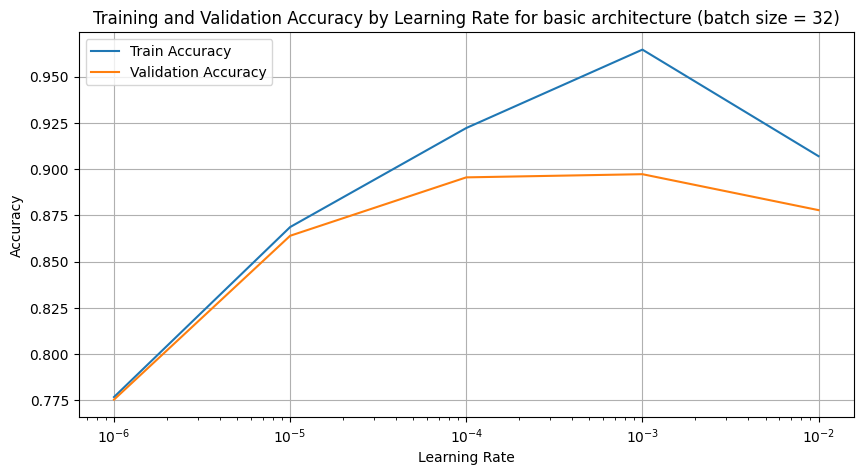

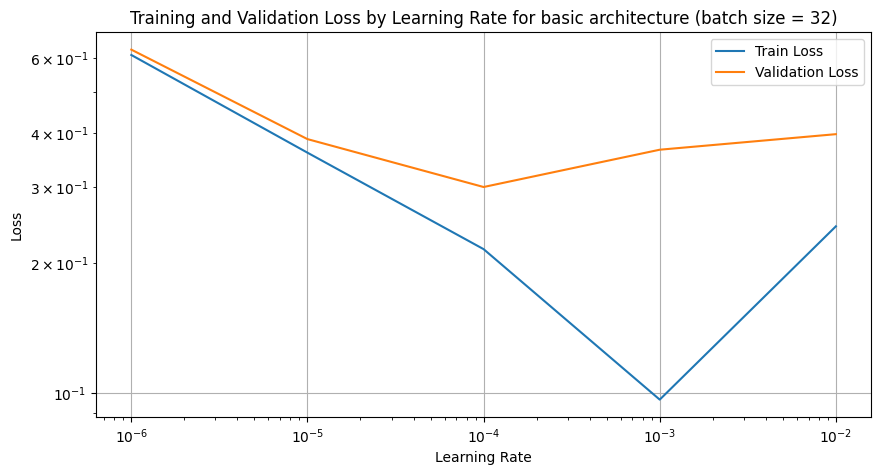

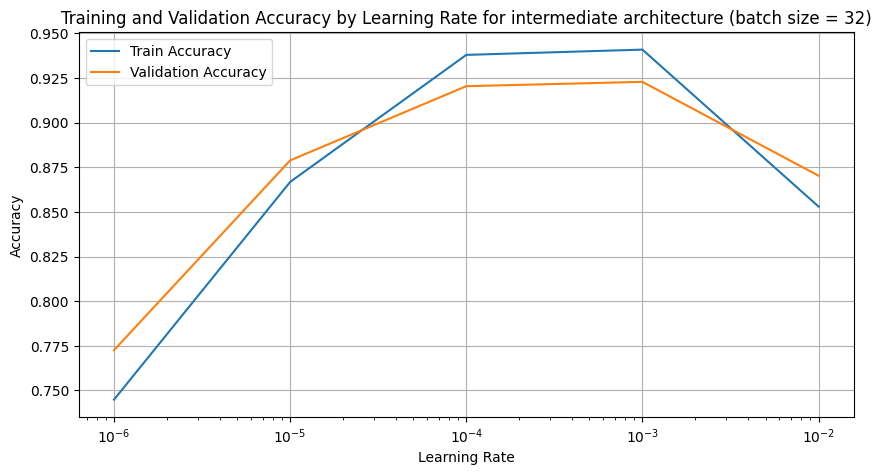

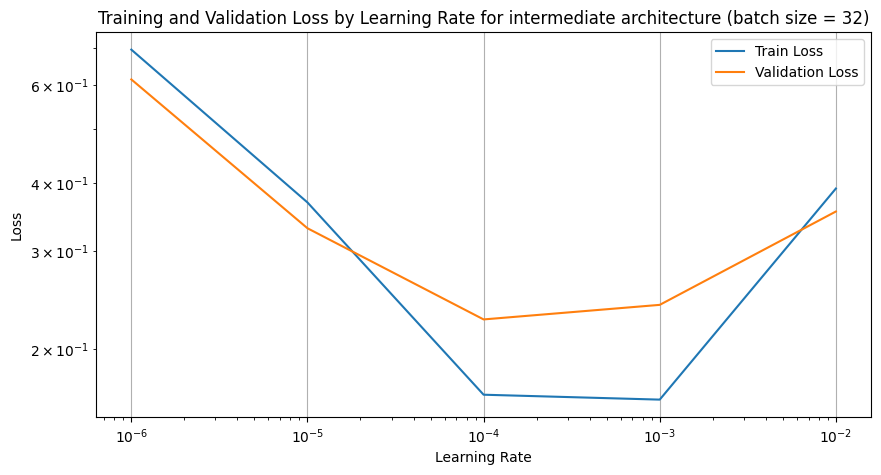

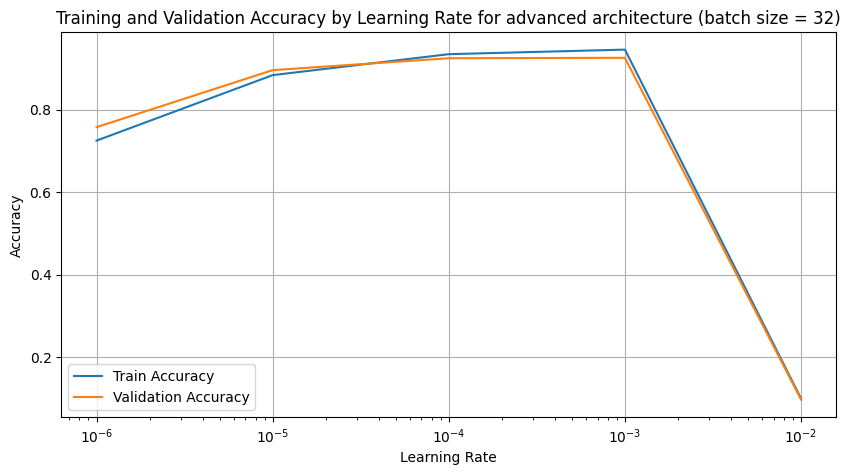

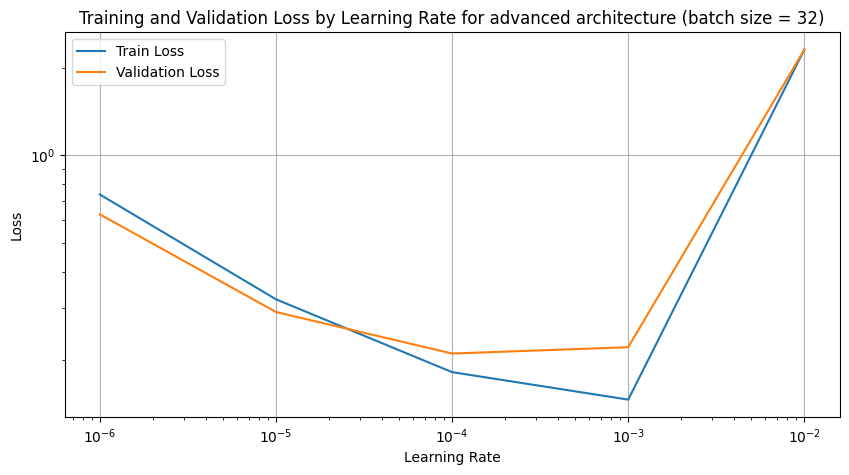

In [ ]:
for architecture in ['basic', 'intermediate', 'advanced']:
  lrs = list(results[architecture].keys())
  train_accuracies = [results[architecture][lr]['last_train_accuracy'] for lr in lrs]
  val_accuracies = [results[architecture][lr]['last_val_accuracy'] for lr in lrs]
  train_losses = [results[architecture][lr]['last_train_loss'] for lr in lrs]
  val_losses = [results[architecture][lr]['last_val_loss'] for lr in lrs]

  # Nustatomas grafikai su nuostolių ir tikslumo metrikomis
  plt.figure(figsize=(10, 5))
  plt.plot(lrs, train_accuracies, label='Train Accuracy')
  plt.plot(lrs, val_accuracies, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy by Learning Rate for {architecture} architecture (batch size = {batch_size})')
  plt.xlabel('Learning Rate')
  plt.ylabel('Accuracy')
  plt.xscale('log')
  plt.legend()
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(lrs, train_losses, label='Train Loss')
  plt.plot(lrs, val_losses, label='Validation Loss')
  plt.title(f'Training and Validation Loss by Learning Rate for {architecture} architecture (batch size = {batch_size})')
  plt.xlabel('Learning Rate')
  plt.ylabel('Loss')
  plt.xscale('log')
  plt.yscale('log')
  plt.legend()
  plt.grid(True)
  plt.show()

## Modelių mokynimas su skirtingomis optimizavimo funkcijomis
Pagal prieš tai apmokintų modelių metrikas yra paimtas geriausias modelio variantas su atitinkamu pradinių mokymo žingsnio dydžiu.

**Geriausias rastas variantas:** `advanced` modelis su `10e-4` pradiniu mokymo žingsniu.

In [ ]:
new_results = {}

for optimizer in ['adam', 'sgd', 'rmsprop']:
  new_results[optimizer] = {}
  print(f"Training model with {optimizer} optimization function:")
  # Modelio sukūrimas
  model = create_model(architecture_type='advanced', optimizer=optimizer, learning_rate=0.0001)

  # Modelio apmokymas
  history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
  )

  # Gaunamos paskutinės epochos metrikos
  last_train_accuracy = history.history['accuracy'][-1]
  last_val_accuracy = history.history['val_accuracy'][-1]
  last_train_loss = history.history['loss'][-1]
  last_val_loss = history.history['val_loss'][-1]

  new_results[optimizer] = {
    'last_train_accuracy': last_train_accuracy,
    'last_val_accuracy': last_val_accuracy,
    'last_train_loss': last_train_loss,
    'last_val_loss': last_val_loss
  }

  # Išsaugojamas modelis
  model_filename = f"model_{optimizer}.h5"
  model.save(model_filename)
  print(f"Model saved as {model_filename}")

Training model with adam optimization function:
Epoch 1/100
1750/1750 [==============================] - 53s 28ms/step - loss: 1.0299 - accuracy: 0.6207 - val_loss: 0.6007 - val_accuracy: 0.7670 - lr: 1.0000e-04
Epoch 2/100
1750/1750 [==============================] - 40s 23ms/step - loss: 0.6629 - accuracy: 0.7487 - val_loss: 0.5197 - val_accuracy: 0.8039 - lr: 1.0000e-04
Epoch 3/100
1750/1750 [==============================] - 25s 14ms/step - loss: 0.5742 - accuracy: 0.7849 - val_loss: 0.4587 - val_accuracy: 0.8309 - lr: 1.0000e-04
Epoch 4/100
1750/1750 [==============================] - 24s 14ms/step - loss: 0.5155 - accuracy: 0.8097 - val_loss: 0.4231 - val_accuracy: 0.8404 - lr: 1.0000e-04
Epoch 5/100
1750/1750 [==============================] - 26s 15ms/step - loss: 0.4693 - accuracy: 0.8281 - val_loss: 0.3877 - val_accuracy: 0.8560 - lr: 1.0000e-04
Epoch 6/100
1750/1750 [==============================] - 26s 15ms/step - loss: 0.4299 - accuracy: 0.8435 - val_loss: 0.3587 - val_ac

## Naujų logaritminių skalių pateikimas kiekvienam modeliui

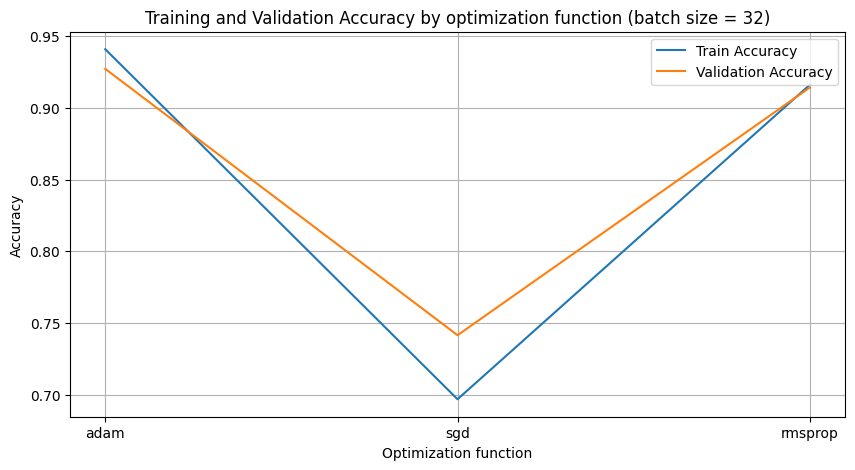

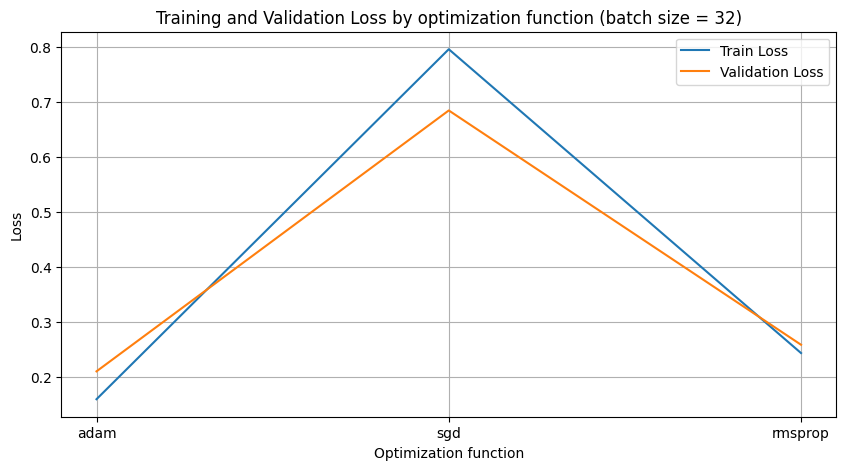

In [ ]:
optimizers = list(new_results.keys())
train_accuracies = [new_results[optimizer]['last_train_accuracy'] for optimizer in optimizers]
val_accuracies = [new_results[optimizer]['last_val_accuracy'] for optimizer in optimizers]
train_losses = [new_results[optimizer]['last_train_loss'] for optimizer in optimizers]
val_losses = [new_results[optimizer]['last_val_loss'] for optimizer in optimizers]

# Nustatomas grafikai su nuostolių ir tikslumo metrikomis
plt.figure(figsize=(10, 5))
plt.plot(optimizers, train_accuracies, label='Train Accuracy')
plt.plot(optimizers, val_accuracies, label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy by optimization function (batch size = {batch_size})')
plt.xlabel('Optimization function')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(optimizers, train_losses, label='Train Loss')
plt.plot(optimizers, val_losses, label='Validation Loss')
plt.title(f'Training and Validation Loss by optimization function (batch size = {batch_size})')
plt.xlabel('Optimization function')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Testavimo duomenų klasifikavimo duomenys

### Modelio įkėlimas

In [6]:
test_model = load_model("model_adam.h5")

### Klasifikavimo tikslumo ir mažiausios paklaidos paskaičiavimas su klasifikavimo matrica

219/219 [==============================] - 4s 16ms/step - loss: 0.1811 - accuracy: 0.9317

Test Loss: 0.18114188313484192
Test Accuracy: 0.9317142963409424

1/1 [==============================] - 0s 169ms/step


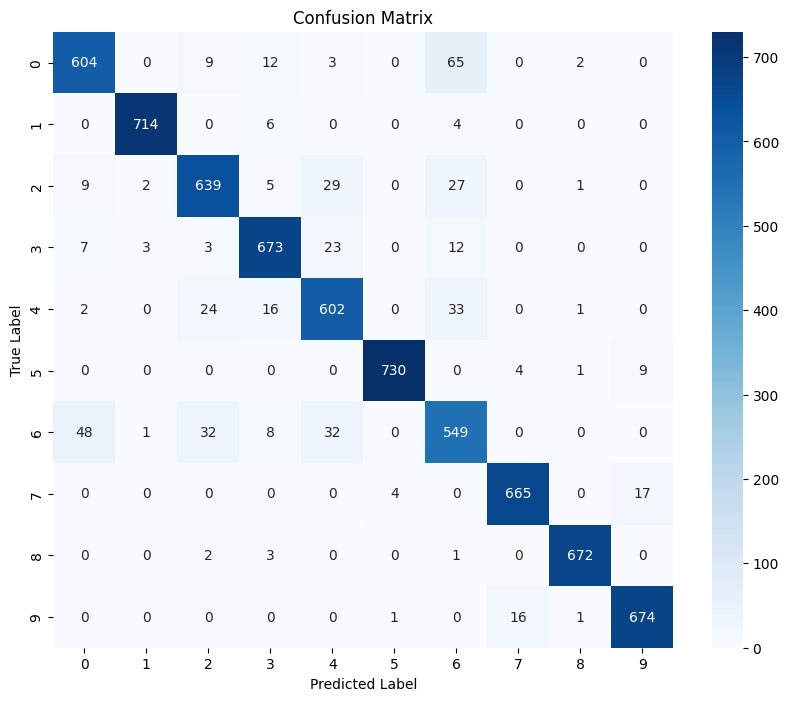

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       695
           1       0.99      0.99      0.99       724
           2       0.90      0.90      0.90       712
           3       0.93      0.93      0.93       721
           4       0.87      0.89      0.88       678
           5       0.99      0.98      0.99       744
           6       0.79      0.82      0.81       670
           7       0.97      0.97      0.97       686
           8       0.99      0.99      0.99       678
           9       0.96      0.97      0.97       692

    accuracy                           0.93      7000
   macro avg       0.93      0.93      0.93      7000
weighted avg       0.93      0.93      0.93      7000



In [7]:
# Modelio testavimas
test_loss, test_accuracy = test_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}\n")

# Gaunamos modelio prognozės ir tikri duomenys iš testavimo rinkinio
y_pred = []
y_true = []

for images, labels in test_dataset:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    predictions = test_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Sukuriama ir atvaizduojama klasifikavimo matrica
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred))

In [8]:
# Gaunami atsitiktiniai testavimo rinkinio paveikslėliai ir jų tikrosios klasės
sample_size = 30
test_images = []
test_labels = []

for images, labels in test_dataset:
    test_images.extend(images.numpy())
    test_labels.extend(np.argmax(labels.numpy(), axis=1))

# Pasirenkami atsitiktiniai paveikslėliai iš testavimo rinkinio
random_indices = random.sample(range(len(test_images)), sample_size)
sample_images = np.array([test_images[i] for i in random_indices])
sample_true_labels = np.array([test_labels[i] for i in random_indices])

# Gaunamos modelio prognozės
sample_predictions = test_model.predict(sample_images)
sample_predicted_labels = np.argmax(sample_predictions, axis=1)

print("Sample Predictions (Predicted vs True):")
for i in range(sample_size):
    print(f"Predicted: {sample_predicted_labels[i]}, True: {sample_true_labels[i]}")

1/1 [==============================] - 0s 34ms/step
Sample Predictions (Predicted vs True):
Predicted: 0, True: 6
Predicted: 0, True: 0
Predicted: 4, True: 4
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 1, True: 1
Predicted: 9, True: 9
Predicted: 2, True: 2
Predicted: 0, True: 0
Predicted: 8, True: 8
Predicted: 7, True: 7
Predicted: 3, True: 3
Predicted: 1, True: 1
Predicted: 8, True: 8
Predicted: 9, True: 9
Predicted: 3, True: 3
Predicted: 8, True: 8
Predicted: 5, True: 5
Predicted: 4, True: 4
Predicted: 5, True: 5
Predicted: 2, True: 2
Predicted: 3, True: 3
Predicted: 8, True: 8
Predicted: 9, True: 9
Predicted: 6, True: 6
Predicted: 8, True: 8
Predicted: 8, True: 8
Predicted: 8, True: 8
Predicted: 7, True: 7
Predicted: 3, True: 3
